In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Tennis Modeling Assigment
#### Question
Given the current state of a match, what is the probability that player 1 will win?
#### Dataset Description
This dataset is composed of various WTA (Womens Tennis Association) matches. It gives point-by-point information about individual games. Player 1 and Player 2 are assigned arbitrarily and it is not encouraged to try to uncover these players identities nor is it worth the time
#### Task
Using a model or models of your choosing, predict the probabilities that player 1 will win the match and evaluate your model
### If you are unfamiliar with how tennis is scored, here are a few of the basics
#### Scoring a game
Tennis has a different point system than most sports
- 0 points= Love
- 1 point = 15
- 2 points= 30
- 3 points= 40
- 40-40 = Deuce

In order to win the game, a player must win at least four points. So if you are up 40-30, 40-15 or 40-love, and win one more point, you win the game. A score of 40-40 is called deuce. When the score reaches deuce, one player will need to win at least two points in a row to win the game
#### Winning a set
To win a set, a player needs to win 6 games, by two (no tie break games will appear in this dataset)
#### Winning a match
In WTA, the first player to win 2 sets wins the match

### *Please include all code used throughout the model creation in this notebook, not just the completed model*

In [180]:
df = pd.read_csv('tennis_data.csv')
df

,game_id,set_num,serving_player,player_1_points,player_2_points,player_1_games,player_2_games,player_1_sets,player_2_sets,match_winning_player
0,1,1,1,0,0,0,0,0,0,2
1,1,1,1,15,0,0,0,0,0,2
2,1,1,1,15,15,0,0,0,0,2
3,1,1,1,30,15,0,0,0,0,2
4,1,1,1,40,15,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...
18500,136,2,1,15,0,5,1,1,0,1
18501,136,2,1,30,0,5,1,1,0,1
18502,136,2,1,30,15,5,1,1,0,1
18503,136,2,1,40,15,5,1,1,0,1


# Exploring the Data

In [181]:
# Get a count of points played by game

def rolling_count(val):
    if val == rolling_count.previous:
        rolling_count.count +=1
    else:
        rolling_count.previous = val
        rolling_count.count = 1
    return rolling_count.count
rolling_count.count = 0 #static variable
rolling_count.previous = None #static variable

df['points_played'] = df['game_id'].apply(rolling_count) - 1

In [182]:
# Stats on Points Played

print('Average Number of Points Played in a Game: ' + str(df.groupby('game_id').max()['points_played'].mean()))
print('Median Number of Points Played in a Game: ' + str(df.groupby('game_id').max()['points_played'].median()))
print('Shortest Game: ' + str(df.groupby('game_id').max()['points_played'].min()))
print('Longest Game: ' + str(df.groupby('game_id').max()['points_played'].max()))


Average Number of Points Played in a Game: 135.06617647058823
Median Number of Points Played in a Game: 125.5
Shortest Game: 36
Longest Game: 235


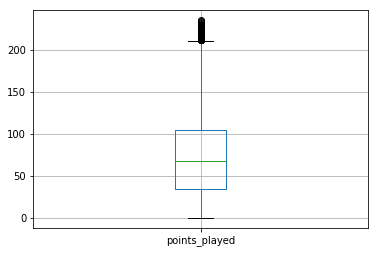

In [183]:
# Box Plot

df.boxplot('points_played')
plt.show()

In [184]:
# most games last around 120 points or so
# How many times has each player won?

win_loss = df[(df['points_played'] == 0)][['match_winning_player', 'game_id']]

win_loss.match_winning_player.value_counts()

2    69
1    67
Name: match_winning_player, dtype: int64

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


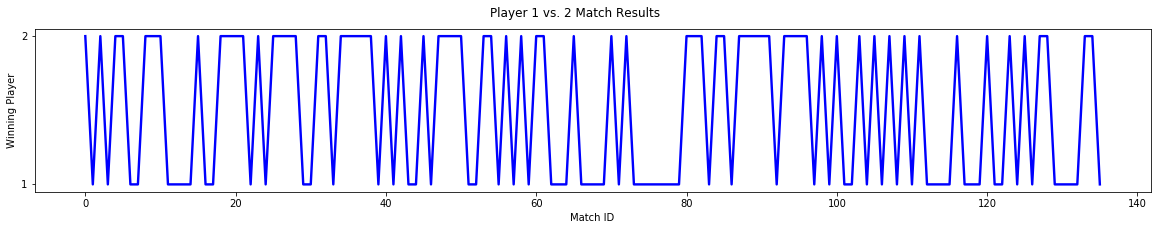

In [185]:
# Pretty even thus far, assuming that the games are chronological
# has there been any streaks or has it been split evenly?

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(win_loss)),win_loss.match_winning_player,'b-',linewidth=2.4)
fig.suptitle('Player 1 vs. 2 Match Results')
ax.set_ylabel('Winning Player')
ax.set_xlabel('Match ID')
plt.locator_params(axis='y', nbins=2)
fig.show()

In [186]:
# looks like player 2 has a few streaks earlier on. what's the score after a certain number of games?

game_ids = [20, 40, 60, 80, 100, 120, 136]

for i in game_ids:
    print('Score by Player After ' + str(i) + ' Games:\n ' + 'Player 1: '\
         + str(len(win_loss[(win_loss['game_id'] <= i) & (win_loss['match_winning_player'] == 1)])) \
         + '   ' + 'Player 2: ' \
          + str(len(win_loss[(win_loss['game_id'] <= i) & (win_loss['match_winning_player'] == 2)])))


#win_loss[win_loss['game_id'] <= 60].match_winning_player.value_counts()


Score by Player After 20 Games:
 Player 1: 10   Player 2: 10
Score by Player After 40 Games:
 Player 1: 16   Player 2: 24
Score by Player After 60 Games:
 Player 1: 25   Player 2: 35
Score by Player After 80 Games:
 Player 1: 40   Player 2: 40
Score by Player After 100 Games:
 Player 1: 45   Player 2: 55
Score by Player After 120 Games:
 Player 1: 58   Player 2: 62
Score by Player After 136 Games:
 Player 1: 67   Player 2: 69


Stays Relatively close but Player 2 mantains a decent lead until game 60, then Player 1 outperforms from 60 to 80 to tie it up. After that Player 2 outperforms again from Games 80 to 100. Player 1 chips away slowly at the last 36 games. Knowing this skew in player 1 performance towards the last quarter of the dataset (which will probably be our test set for prediction), it will be interesting to see the model performance, especially at the first point of the match.

In [187]:
# Create a match_streak column:

win_loss['player_1_match_streak'] = 0
win_loss['player_2_match_streak'] = 0

win_loss['player_1_win'] = win_loss['match_winning_player'].apply(lambda x: 1 if x == 1 else 0)
win_loss['player_2_win'] = win_loss['match_winning_player'].apply(lambda x: 1 if x == 2 else 0)

win_loss['player_1_match_streak'] = ((win_loss['player_1_win'] == win_loss['player_1_win'].shift()) & (win_loss['match_winning_player'] == 1)).apply(lambda x: 1 if x == True else 0)
win_loss['player_2_match_streak'] = ((win_loss['player_2_win'] == win_loss['player_2_win'].shift()) & (win_loss['match_winning_player'] == 2)).apply(lambda x: 1 if x == True else 0)

win_loss['player_1_match_streak'] = win_loss['player_1_match_streak'] * (win_loss.groupby((win_loss['player_1_match_streak'] > win_loss['player_1_match_streak'].shift()).cumsum()).cumcount() + 1)
win_loss['player_2_match_streak'] = win_loss['player_2_match_streak'] * (win_loss.groupby((win_loss['player_2_match_streak'] > win_loss['player_2_match_streak'].shift()).cumsum()).cumcount() + 1)

In [188]:
win_loss[['match_winning_player', 'player_1_match_streak', 'player_2_match_streak']].head(50)

,match_winning_player,player_1_match_streak,player_2_match_streak
0,2,0,0
145,1,0,0
255,2,0,0
416,1,0,0
481,2,0,0
614,2,0,1
738,1,0,0
825,1,1,0
989,2,0,0
1114,2,0,1


In [189]:
# Streak Stats

# Longest Streak
print('Longest Streak for Player 1: ' + str(win_loss['player_1_match_streak'].max()))
print('Longest Streak for Player 2: ' + str(win_loss['player_2_match_streak'].max()))
print('')

# Longest Streak in first half 
print('Longest Streak for Player 1 in First Half: ' + str(win_loss[win_loss['game_id'] <= 67]['player_1_match_streak'].max()))
print('Longest Streak for Player 2 in First Half: ' + str(win_loss[win_loss['game_id'] <= 67]['player_2_match_streak'].max()))
print('')

# Longest Streak in first half 
print('Longest Streak for Player 1 in Second Half: ' + str(win_loss[win_loss['game_id'] > 67]['player_1_match_streak'].max()))
print('Longest Streak for Player 2 in Second Half: ' + str(win_loss[win_loss['game_id'] > 67]['player_2_match_streak'].max()))
print('')
# Number of Streaks of 3 games or more

print('Number of Streaks of 3 or more for Player 1: ' + str(len(win_loss[win_loss['player_1_match_streak'] >= 3])))
print('Number of Streaks of 3 or more for Player 2: ' + str(len(win_loss[win_loss['player_2_match_streak'] >= 3])))      
      

Longest Streak for Player 1: 6
Longest Streak for Player 2: 4

Longest Streak for Player 1 in First Half: 3
Longest Streak for Player 2 in First Half: 4

Longest Streak for Player 1 in Second Half: 6
Longest Streak for Player 2 in Second Half: 4

Number of Streaks of 3 or more for Player 1: 8
Number of Streaks of 3 or more for Player 2: 8


More proof that Player 1 performed better in the later games. Player 2 was more consistent throughout the dataset.

# Model Feature Selection

After exploring the data and using some tennis knowledge here are some potential feature ideas for a predictive model:

- set number
- player 1 points
- player 2 points 
- player 1 games 
- player 2 games 
- player 1 sets 
- player 2 sets 
- player 1 point streak
- player 2 point streak
- player 1 point diff 
- player 1 set diff 
- player 1 point win percentage (if player 1 is serving, the percent of points that player 1 has won when serving, if player 1 is receiving, the percent of points that player 1 has won when receiving)
- player 1 match win streak
- player 2 match win streak
- points played in game

The dataset is very clean and pretty close to being ready for modeling. We will most likely be dropping fields with duplicative information such as the scoring fields. We can use the calculated fields (player 1 point diff) of the point features (player 1 points, games, sets) to reduce the dimensionality as well as adding some features with information on the players momentum (point streak, match streak), a feature that has information on serve performance as that is a critical piece of information in tennis, and lastly the match duration.

In [192]:
# Clean up point columns

df['player_1_points'] = df['player_1_points'].replace(15, 1)
df['player_2_points'] = df['player_2_points'].replace(15, 1)
df['player_1_points'] = df['player_1_points'].replace(30, 2)
df['player_2_points'] = df['player_2_points'].replace(30, 2)
df['player_1_points'] = df['player_1_points'].replace(40, 3)
df['player_2_points'] = df['player_2_points'].replace(40, 3)
df['player_1_points'] = df['player_1_points'].replace('AD', 4)
df['player_2_points'] = df['player_2_points'].replace('AD', 4)



In [193]:
df['player_1_points']

0        0
1        1
2        1
3        2
4        3
        ..
18500    1
18501    2
18502    2
18503    3
18504    3
Name: player_1_points, Length: 18505, dtype: int64

In [194]:
# score differential columns

df['player_1_point_diff'] = df['player_1_points'] - df['player_2_points']
df['player_1_game_diff'] = df['player_1_games'] - df['player_2_games']
df['player_1_set_diff'] = df['player_1_sets'] - df['player_2_sets']

In [195]:
df['player_1_point_diff']

0        0
1        1
2        0
3        1
4        2
        ..
18500    1
18501    2
18502    1
18503    2
18504    1
Name: player_1_point_diff, Length: 18505, dtype: int64

In [196]:
# create point streak columns

df['player_1_point_streak'] = 0
df['player_2_point_streak'] = 0

# convert to binary values

df['player_1_point_streak'] = ((df['player_1_points'] > df['player_1_points'].shift()) | (df['player_1_games'] > df['player_1_games'].shift())).apply(lambda x: 1 if x == True else 0)
df['player_2_point_streak'] = ((df['player_2_points'] > df['player_2_points'].shift()) | (df['player_2_games'] > df['player_2_games'].shift())).apply(lambda x: 1 if x == True else 0)

# adds up each consecutive win

df['player_1_point_streak'] = df['player_1_point_streak'] * (df.groupby((df['player_1_point_streak'] > df['player_1_point_streak'].shift()).cumsum()).cumcount() + 1)
df['player_2_point_streak'] = df['player_2_point_streak'] * (df.groupby((df['player_2_point_streak'] > df['player_2_point_streak'].shift()).cumsum()).cumcount() + 1)


In [197]:
df.head(30)

,game_id,set_num,serving_player,player_1_points,player_2_points,player_1_games,player_2_games,player_1_sets,player_2_sets,match_winning_player,points_played,player_1_point_diff,player_1_game_diff,player_1_set_diff,player_1_point_streak,player_2_point_streak
0,1,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,2,1,1,0,0,1,0
2,1,1,1,1,1,0,0,0,0,2,2,0,0,0,0,1
3,1,1,1,2,1,0,0,0,0,2,3,1,0,0,1,0
4,1,1,1,3,1,0,0,0,0,2,4,2,0,0,2,0
5,1,1,1,3,2,0,0,0,0,2,5,1,0,0,0,1
6,1,1,1,3,3,0,0,0,0,2,6,0,0,0,0,2
7,1,1,1,3,4,0,0,0,0,2,7,-1,0,0,0,3
8,1,1,2,0,0,0,1,0,0,2,8,0,-1,0,0,4
9,1,1,2,1,0,0,1,0,0,2,9,1,-1,0,1,0


In [198]:
# field for win rate of serving vs. receiving 

# serve percentage

df['serve_count'] = df.groupby('serving_player').cumcount()
df['player_1_serve_points'] = ((df['serving_player'] == 1) & (df['player_1_points'] > df['player_1_points'].shift())).apply(lambda x: 1 if x == True else 0)
df['player_1_serve_point_total'] = df.groupby('serving_player')['player_1_serve_points'].cumsum()
df['player_1_serve_win_percentage'] = df['player_1_serve_point_total'] / df['serve_count']

# receive percentage

df['receiving_player'] = df['serving_player'].apply(lambda x: 2 if x == 1 else 1)
df['receive_count'] = df.groupby('receiving_player').cumcount()
df['player_1_receive_points'] = ((df['receiving_player'] == 1) & (df['player_1_points'] > df['player_1_points'].shift())).apply(lambda x: 1 if x == True else 0)
df['player_1_receive_point_total'] = df.groupby('receiving_player')['player_1_receive_points'].cumsum()
df['player_1_receive_win_percentage'] = df['player_1_receive_point_total'] / df['receive_count']

df = df.fillna(0)

# "coalesce" to form one column, can never never be serving and receiving in same row so each value gets added with 0

df['player_1_point_win_percentage'] = df['player_1_serve_win_percentage'] + df['player_1_receive_win_percentage']

In [199]:
df.head(30)

,game_id,set_num,serving_player,player_1_points,player_2_points,player_1_games,player_2_games,player_1_sets,player_2_sets,match_winning_player,...,serve_count,player_1_serve_points,player_1_serve_point_total,player_1_serve_win_percentage,receiving_player,receive_count,player_1_receive_points,player_1_receive_point_total,player_1_receive_win_percentage,player_1_point_win_percentage
0,1,1,1,0,0,0,0,0,0,2,...,0,0,0,0.000000,2,0,0,0,0.000000,0.000000
1,1,1,1,1,0,0,0,0,0,2,...,1,1,1,1.000000,2,1,0,0,0.000000,1.000000
2,1,1,1,1,1,0,0,0,0,2,...,2,0,1,0.500000,2,2,0,0,0.000000,0.500000
3,1,1,1,2,1,0,0,0,0,2,...,3,1,2,0.666667,2,3,0,0,0.000000,0.666667
4,1,1,1,3,1,0,0,0,0,2,...,4,1,3,0.750000,2,4,0,0,0.000000,0.750000
5,1,1,1,3,2,0,0,0,0,2,...,5,0,3,0.600000,2,5,0,0,0.000000,0.600000
6,1,1,1,3,3,0,0,0,0,2,...,6,0,3,0.500000,2,6,0,0,0.000000,0.500000
7,1,1,1,3,4,0,0,0,0,2,...,7,0,3,0.428571,2,7,0,0,0.000000,0.428571
8,1,1,2,0,0,0,1,0,0,2,...,0,0,0,0.000000,1,0,0,0,0.000000,0.000000
9,1,1,2,1,0,0,1,0,0,2,...,1,0,0,0.000000,1,1,1,1,1.000000,1.000000


In [200]:
# add match streak to df 

df = df.merge(win_loss, how='left', left_on='game_id', right_on='game_id')

df[df['player_1_match_streak'] == 6]

,game_id,set_num,serving_player,player_1_points,player_2_points,player_1_games,player_2_games,player_1_sets,player_2_sets,match_winning_player_x,...,receive_count,player_1_receive_points,player_1_receive_point_total,player_1_receive_win_percentage,player_1_point_win_percentage,match_winning_player_y,player_1_match_streak,player_2_match_streak,player_1_win,player_2_win
10757,80,1,1,0,0,0,0,0,0,1,...,5371,0,0,0.0,0.458201,1,6,0,1,0
10758,80,1,1,0,1,0,0,0,0,1,...,5372,0,0,0.0,0.458116,1,6,0,1,0
10759,80,1,1,0,2,0,0,0,0,1,...,5373,0,0,0.0,0.458031,1,6,0,1,0
10760,80,1,1,0,3,0,0,0,0,1,...,5374,0,0,0.0,0.457946,1,6,0,1,0
10761,80,1,1,1,3,0,0,0,0,1,...,5375,0,0,0.0,0.458047,1,6,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10865,80,2,1,2,1,6,5,1,0,1,...,5422,0,0,0.0,0.458687,1,6,0,1,0
10866,80,2,1,2,2,6,5,1,0,1,...,5423,0,0,0.0,0.458602,1,6,0,1,0
10867,80,2,1,2,3,6,5,1,0,1,...,5424,0,0,0.0,0.458518,1,6,0,1,0
10868,80,2,1,3,3,6,5,1,0,1,...,5425,0,0,0.0,0.458618,1,6,0,1,0


# Modeling

For predictive modeling we will take a look at Logistic Regression, a Random Forest, and a Boosted Tree. 

With a relatively simple and intuitive dataset, a linear model such as Logistic Regression is a good candidate to perform well taking intuitive imputs like score, match progress, and win percentages on serving points vs receiving points. The relationship between these features are and the match result are linear.

We will take a look at two tree based ensemble methods in Random Forest and Gradient Boosted Trees as well. With relatively linear inputs, we should not expect much increase in performance from these ensemble methods due to the simple, linear relationships of our features and the overall small dimensionality. However, it will be interesting to see if the learning rate from boosting will lead to higher performance.

To Reduce the potential over overfitting, we will use cross validation during training. Since we are working with chronological data, we must make sure that we aren't using future games to help predict games in the past. We will use Sci-kit learn's TimeSeriesSplit class to do that. We will use accuracy score for our training evaluation metrics since we have a balanced target class and include Precision-Recall to see where the models prediction biases towards.

In [203]:
df.columns

Index(['game_id', 'set_num', 'serving_player', 'player_1_points',
       'player_2_points', 'player_1_games', 'player_2_games', 'player_1_sets',
       'player_2_sets', 'match_winning_player_x', 'points_played',
       'player_1_point_diff', 'player_1_game_diff', 'player_1_set_diff',
       'player_1_point_streak', 'player_2_point_streak', 'serve_count',
       'player_1_serve_points', 'player_1_serve_point_total',
       'player_1_serve_win_percentage', 'receiving_player', 'receive_count',
       'player_1_receive_points', 'player_1_receive_point_total',
       'player_1_receive_win_percentage', 'player_1_point_win_percentage',
       'match_winning_player_y', 'player_1_match_streak',
       'player_2_match_streak', 'player_1_win', 'player_2_win'],
      dtype='object')

In [204]:
all_feats = [
    'game_id'
    , 'set_num'
    , 'serving_player'
    , 'player_1_points'
    , 'player_2_points'
    , 'player_1_games'
    , 'player_2_games'
    , 'player_1_sets'
    , 'player_2_sets'
    , 'player_1_point_streak'
    , 'player_2_point_streak'
    , 'player_1_point_diff'
    , 'player_1_game_diff'
    , 'player_1_set_diff'
    , 'points_played'
    , 'player_1_point_win_percentage'
    , 'player_1_match_streak'
    , 'player_2_match_streak'
    , 'match_winning_player_x'
    
]

In [205]:
# check for multicollinearity for LR
df[all_feats].corr()

,game_id,set_num,serving_player,player_1_points,player_2_points,player_1_games,player_2_games,player_1_sets,player_2_sets,player_1_point_streak,player_2_point_streak,player_1_point_diff,player_1_game_diff,player_1_set_diff,points_played,player_1_point_win_percentage,player_1_match_streak,player_2_match_streak,match_winning_player_x
game_id,1.000000,0.053435,0.006749,0.022872,0.008949,-0.010087,-0.015208,0.105107,-0.029598,0.007221,0.000855,0.014462,0.004851,0.099304,0.040378,-0.022243,0.105172,-0.152314,-0.134328
set_num,0.053435,1.000000,0.022821,-0.023604,0.021507,-0.061374,0.045297,0.739960,0.717233,-0.011071,0.032599,-0.047018,-0.103500,0.035372,0.881549,-0.028097,-0.011917,-0.029413,-0.003488
serving_player,0.006749,0.022821,1.000000,-0.036871,0.103539,0.074090,-0.012633,0.022393,0.010663,0.008743,0.010786,-0.146460,0.084365,0.008989,0.034419,-0.972163,0.016337,-0.009303,-0.028334
player_1_points,0.022872,-0.023604,-0.036871,1.000000,0.539799,0.003554,-0.020998,0.005691,-0.040920,0.109738,-0.383592,0.477252,0.023725,0.033571,0.023005,0.043191,0.035366,-0.029351,-0.077123
player_2_points,0.008949,0.021507,0.103539,0.539799,1.000000,-0.003859,0.017686,0.003240,0.028555,-0.396069,0.134492,-0.482120,-0.020827,-0.018069,0.067528,-0.103366,-0.011738,0.009822,0.038847
player_1_games,-0.010087,-0.061374,0.074090,0.003554,-0.003859,1.000000,0.468180,0.002529,-0.093686,0.122177,-0.028342,0.007727,0.522316,0.069059,0.290347,-0.069364,0.103676,-0.078610,-0.162399
player_2_games,-0.015208,0.045297,-0.012633,-0.020998,0.017686,0.468180,1.000000,-0.011991,0.079633,-0.075876,0.149471,-0.040317,-0.508982,-0.066011,0.362027,0.007874,-0.089810,0.104782,0.231955
player_1_sets,0.105107,0.739960,0.022393,0.005691,0.003240,0.002529,-0.011991,1.000000,0.061998,0.034115,-0.004745,0.002541,0.014035,0.698404,0.646872,-0.021611,0.152639,-0.195605,-0.324349
player_2_sets,-0.029598,0.717233,0.010663,-0.040920,0.028555,-0.093686,0.079633,0.061998,1.000000,-0.051767,0.053286,-0.072397,-0.168113,-0.671027,0.637911,-0.019302,-0.175809,0.158994,0.330834
player_1_point_streak,0.007221,-0.011071,0.008743,0.109738,-0.396069,0.122177,-0.075876,0.034115,-0.051767,1.000000,-0.447534,0.527676,0.192241,0.062464,-0.015157,-0.005500,0.030025,-0.052134,-0.121229


It appers that set_num is a column to drop. With points played containing more granular information on the match progress and having several score columns, set number is duplicative information. The game and set count fields are also duplicative and can be dropped.

In [206]:
feats = [
    'game_id'
    , 'player_1_point_streak'
    , 'player_2_point_streak'
    , 'player_1_point_diff'
    , 'player_1_game_diff'
    , 'player_1_set_diff'
    , 'points_played'
    , 'player_1_point_win_percentage'
    , 'player_1_match_streak'
    , 'player_2_match_streak'
    , 'match_winning_player_x'
]

In [207]:
df[feats].corr()

,game_id,player_1_point_streak,player_2_point_streak,player_1_point_diff,player_1_game_diff,player_1_set_diff,points_played,player_1_point_win_percentage,player_1_match_streak,player_2_match_streak,match_winning_player_x
game_id,1.000000,0.007221,0.000855,0.014462,0.004851,0.099304,0.040378,-0.022243,0.105172,-0.152314,-0.134328
player_1_point_streak,0.007221,1.000000,-0.447534,0.527676,0.192241,0.062464,-0.015157,-0.005500,0.030025,-0.052134,-0.121229
player_2_point_streak,0.000855,-0.447534,1.000000,-0.539626,-0.171856,-0.041735,0.045039,-0.016351,-0.052081,0.056444,0.134350
player_1_point_diff,0.014462,0.527676,-0.539626,1.000000,0.046435,0.053802,-0.046551,0.152857,0.049060,-0.040800,-0.120820
player_1_game_diff,0.004851,0.192241,-0.171856,0.046435,1.000000,0.130977,-0.066539,-0.075169,0.187665,-0.177696,-0.382047
player_1_set_diff,0.099304,0.062464,-0.041735,0.053802,0.130977,1.000000,0.023102,-0.002213,0.239460,-0.259319,-0.478182
points_played,0.040378,-0.015157,0.045039,-0.046551,-0.066539,0.023102,1.000000,-0.040164,0.022918,-0.034397,0.005583
player_1_point_win_percentage,-0.022243,-0.005500,-0.016351,0.152857,-0.075169,-0.002213,-0.040164,1.000000,-0.000799,0.002038,0.024248
player_1_match_streak,0.105172,0.030025,-0.052081,0.049060,0.187665,0.239460,0.022918,-0.000799,1.000000,-0.192431,-0.427454
player_2_match_streak,-0.152314,-0.052134,0.056444,-0.040800,-0.177696,-0.259319,-0.034397,0.002038,-0.192431,1.000000,0.450179


In [208]:
final_df = df[feats]

In [209]:
# 75-25 split for train-test, make sure test is the last quarter of the dataset

c = int(max(final_df['game_id']*0.75))

pred_feats = [col for col in feats if col not in ['game_id', 'match_winning_player_x']]

train_df, test_df = final_df[final_df['game_id'] <= c], final_df[final_df['game_id'] > c] 

X_train, y_train = train_df[pred_feats].values, train_df[['match_winning_player_x']].values
X_test, y_test = test_df[pred_feats].values, test_df[['match_winning_player_x']].values

In [210]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [211]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBR', GradientBoostingClassifier()))

In [213]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=5)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(cv_results)
    print(msg)

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/U

[0.78933902 0.89552239 0.80511727 0.89850746 0.81449893]
LR: 0.840597 (0.046771)


/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

[0.80127932 0.85927505 0.74882729 0.91044776 0.80767591]
RF: 0.825501 (0.055027)


/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.81023454 0.8891258  0.82473348 0.91002132 0.8098081 ]
GBR: 0.848785 (0.042335)


In [216]:
# GBR wins in training, LR a close second, validation sets 3 and 5 appear to be the most difficult to predict
# Make predictions on validation dataset
LR = LogisticRegression()
LR.fit(X_train, y_train)
predictions = LR.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7887133182844244
[[2167  477]
 [ 459 1327]]
              precision    recall  f1-score   support

           1       0.83      0.82      0.82      2644
           2       0.74      0.74      0.74      1786

   micro avg       0.79      0.79      0.79      4430
   macro avg       0.78      0.78      0.78      4430
weighted avg       0.79      0.79      0.79      4430



/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [215]:
GBR = GradientBoostingClassifier()
GBR.fit(X_train, y_train)
predictions = GBR.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7663656884875847
[[2050  594]
 [ 441 1345]]
              precision    recall  f1-score   support

           1       0.82      0.78      0.80      2644
           2       0.69      0.75      0.72      1786

   micro avg       0.77      0.77      0.77      4430
   macro avg       0.76      0.76      0.76      4430
weighted avg       0.77      0.77      0.77      4430



# Time Based Evaluation

Logistic Regression is the outright winner in out of sample testing. We see a big of overfitting with our test accuracy being ~ 6 percentage points lower than our average train accuracy which is the challenge of predicting time series data. However 78.7% is still solid performance, especially compared to a baseline of 50%. Looking at the classification report, it appears that the model does a better job of predicting player 1 vs. player 2 and there is no deviation between precision and recall. 

It will be interesting to take a look at how the game performs as the game progresses. What does player 1 win's probability look like when a match begins and at what point are we most confident in player 1 probability of winning? At what stage of the game does the model perform the best?

In [244]:
LR.predict_proba(X_test)

array([[0.994733  , 0.005267  ],
       [0.99510142, 0.00489858],
       [0.99397959, 0.00602041],
       ...,
       [0.98401804, 0.01598196],
       [0.98699634, 0.01300366],
       [0.98404811, 0.01595189]])

In [217]:
# add predictions and probabilities to test dataframe

test_df['player_1_win_prob'] = LR.predict_proba(X_test)[:, 0]
test_df['predicted_winner'] = LR.predict(X_test)

test_df

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,game_id,player_1_point_streak,player_2_point_streak,player_1_point_diff,player_1_game_diff,player_1_set_diff,points_played,player_1_point_win_percentage,player_1_match_streak,player_2_match_streak,match_winning_player_x,player_1_win_prob,predicted_winner
14075,103,0,0,0,0,0,0,0.452084,1,0,1,0.994733,1
14076,103,1,0,1,0,0,1,0.452162,1,0,1,0.995101,1
14077,103,0,1,0,0,0,2,0.452098,1,0,1,0.993980,1
14078,103,1,0,1,0,0,3,0.452175,1,0,1,0.995111,1
14079,103,2,0,2,0,0,4,0.452253,1,0,1,0.995453,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18500,136,3,0,1,4,1,73,0.453010,0,0,1,0.983956,1
18501,136,4,0,2,4,1,74,0.453069,0,0,1,0.985067,1
18502,136,0,1,1,4,1,75,0.453020,0,0,1,0.984018,1
18503,136,1,0,2,4,1,76,0.453079,0,0,1,0.986996,1


In [218]:
# create a function to look at win probability charts for a particular match

def plot_win_prob(match_id):
    
    df_match_id = test_df[test_df['game_id'] == match_id]
    match_id_probs = df_match_id['player_1_win_prob']
    
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(1,1,1)
    ax.plot(np.arange(len(match_id_probs)),match_id_probs,'b-',linewidth=2.4)
    fig.suptitle('Match {match} Player 1 In Game Win Probability'.format(match=match_id))
    ax.set_ylabel('Player 1 win probability')
    ax.set_xlabel('# points played')
    ax.set_ylim([0, 1])
    fig.show()

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


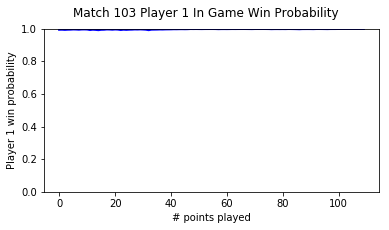

In [219]:
# first 5 matches in test dataframe

plot_win_prob(103)

In [163]:
# interesting that the model was extremely confident in player 1 from match start


test_df[test_df['game_id'] == 103]

,game_id,player_1_point_streak,player_2_point_streak,player_1_point_diff,player_1_game_diff,player_1_set_diff,points_played,player_1_point_win_percentage,player_1_match_streak,player_2_match_streak,match_winning_player_x,player_1_win_prob,predicted_winner
14075,103,0,0,0,0,0,0,0.426850,1,0,1,0.994825,1
14076,103,1,0,15,0,0,1,0.426931,1,0,1,0.994796,1
14077,103,0,1,0,0,0,2,0.426871,1,0,1,0.993817,1
14078,103,1,0,15,0,0,3,0.426952,1,0,1,0.994806,1
14079,103,2,0,25,0,0,4,0.427033,1,0,1,0.994780,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14180,103,0,1,-15,2,1,105,0.342704,1,0,1,0.999754,1
14181,103,0,2,-30,2,1,106,0.342655,1,0,1,0.999706,1
14182,103,1,0,-15,2,1,107,0.342748,1,0,1,0.999794,1
14183,103,2,0,0,2,1,108,0.342841,1,0,1,0.999793,1


/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


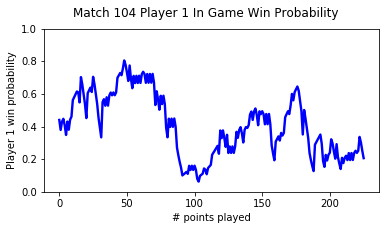

In [220]:
plot_win_prob(104)

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


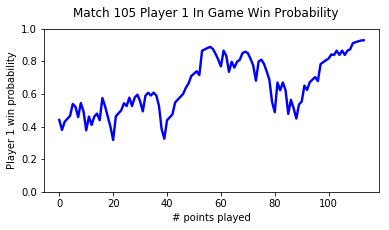

In [221]:
plot_win_prob(105)

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


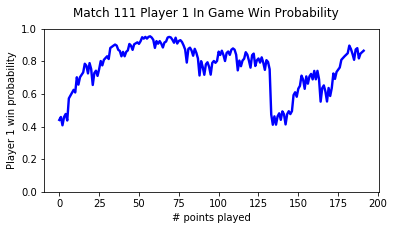

In [227]:
plot_win_prob(111)

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


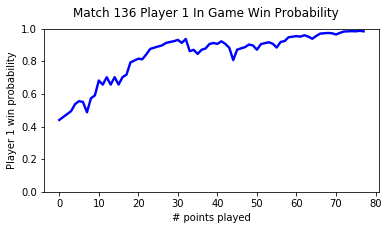

In [226]:
plot_win_prob(136)

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


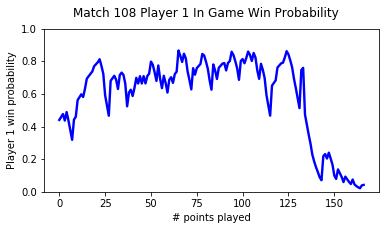

In [224]:
# steady trend for the last match 

plot_win_prob(108)

In [243]:
# big turn of events in match 108 towards the end of the match

# how does the model perform as the match progresses?
# recall from exploring the data that most matches are within 150 points played

accuracy_scores = []

for i in range(150):
    accuracy_scores.append(
        accuracy_score(test_df['predicted_winner'][test_df['points_played'] == i].values, test_df['match_winning_player_x'][test_df['points_played'] == i].values))
    print('Points Played: ' + str(i))
    print(accuracy_score(test_df['predicted_winner'][test_df['points_played'] == i].values, test_df['match_winning_player_x'][test_df['points_played'] == i].values))

Points Played: 0
0.6764705882352942
Points Played: 1
0.6764705882352942
Points Played: 2
0.6764705882352942
Points Played: 3
0.6764705882352942
Points Played: 4
0.6764705882352942
Points Played: 5
0.7941176470588235
Points Played: 6
0.8823529411764706
Points Played: 7
0.7647058823529411
Points Played: 8
0.8823529411764706
Points Played: 9
0.8235294117647058
Points Played: 10
0.7941176470588235
Points Played: 11
0.7941176470588235
Points Played: 12
0.7352941176470589
Points Played: 13
0.7647058823529411
Points Played: 14
0.7058823529411765
Points Played: 15
0.6470588235294118
Points Played: 16
0.7352941176470589
Points Played: 17
0.7058823529411765
Points Played: 18
0.7352941176470589
Points Played: 19
0.7352941176470589
Points Played: 20
0.7647058823529411
Points Played: 21
0.7058823529411765
Points Played: 22
0.7058823529411765
Points Played: 23
0.7352941176470589
Points Played: 24
0.7058823529411765
Points Played: 25
0.7647058823529411
Points Played: 26
0.7647058823529411
Points Play

/Users/kaivonahmad/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


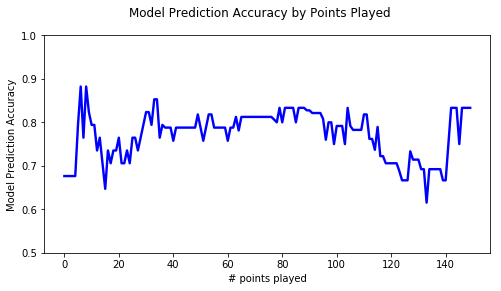

In [235]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(accuracy_scores)),accuracy_scores,'b-',linewidth=2.4)
fig.suptitle('Model Prediction Accuracy by Points Played')
ax.set_ylabel('Model Prediction Accuracy')
ax.set_xlabel('# points played')
ax.set_ylim([0.5, 1])
fig.show()

It is impressive that the model performs well at the beginning of the match, and actually tops within the first 10 or so points. However, after those first 10 points it dives quite a bit lower, all the way down to worse than the beginning of the match. Once the model gets a feel for the game around 30 points in, it is relatively stable. The volatility of the model starts to increase severely for games that last around 115 points. At first glance, these instances could be games where a player has a a relatively solid lead in games and sets after 60 or so points, and then slowly loses that lead to the opponent, setting up a final set with less confidence in prediction. Overall, the reduction in dimensionality of game score and added features with player form/momentum information appears to have made a model that is able to predict player 1's probability of winning relatively well.

Some potential next steps to improve our model would be to identify what events are leading culprits of probability inflection points. This could advise an additional feature that could identify how important a certain point was. We could also spend some more time with hyperparameter optimization to further improve model performance and even try to apply a deep learning approach like a Recurrent Neural Network.